In [9]:
import json
import ast
import matplotlib.pyplot as plt
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
from shared import generate


In [10]:
# *Indirect Speech Act*, *Workplace*


In [11]:
### **Generate Data**


In [ ]:
def generate_indirect_dialogue_workplace():
  return generate(model = '4o-mini',
        system = '''You are an expert in generating dialogues that clearly demonstrate communication challenges with indirect speech acts. . 
        Focus on creating scenarios where Speaker 2 completely misses the indirect intent and responds only to the literal meaning.''',
        query = '''Create 20 different and independent two-message dialogues following these strict rules:

1. Speaker 1's message should be an indirect speech act that is for example:
   - A statement/question with an implicit request or intent.

  
   
2. Speaker 2's response MUST:
   - MISS the indirect intent. 
   - Respond to the literal meaning
   - Show CLEAR MISUNDERSTANDING of the implicit request/suggestion
   - NOT respond appropriately. 
   - 
   
Some good pairs:
- S1: "Can you open the window?." 
  S2: "Yes, I can. Why do you ask?" 
- S1: Can you move the desk to the other room?"
  S2: "Yes, I think I’m strong enough to do that if needed."

IMPORTANT: The misinterpretation should be obvious from the dialogue alone. 

Assume the two speakers are workplace colleagues. YOU MUST GIVE OUTPUT IN THIS FORMAT: [{"Speaker 1": "Message by Speaker 1.", "Speaker 2":"Message by Speaker 2."}]''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)

In [68]:
indirect_statements_workplace = []
while(len(indirect_statements_workplace) < 100):
    output = ast.literal_eval(generate_indirect_dialogue_workplace()['response'])
    indirect_statements_workplace = output + indirect_statements_workplace

indirect_statements_workplace = indirect_statements_workplace[0:100]


In [69]:
indirect_statements_workplace[0:8]


[{'Speaker 1': "I'm really cold in here.",
  'Speaker 2': 'Oh, do you want me to grab a sweater for you?'},
 {'Speaker 1': 'It would be great if we had more snacks in the break room.',
  'Speaker 2': 'Yeah, snacks are nice. I love chips!'},
 {'Speaker 1': "I'm struggling to find my notes.",
  'Speaker 2': "Have you checked your desk? It's a little messy."},
 {'Speaker 1': 'We might need more volunteers for the event.',
  'Speaker 2': 'I agree! Volunteers are really helpful.'},
 {'Speaker 1': "It's really late already.",
  'Speaker 2': 'Yeah, I wish I could leave work early today.'},
 {'Speaker 1': "I can't believe how busy it is today.",
  'Speaker 2': 'Yes, Mondays are always like that!'},
 {'Speaker 1': 'I’m not sure if this project is going to fit our timeline.',
  'Speaker 2': 'Well, we can always request an extension if needed.'},
 {'Speaker 1': 'This coffee is too strong for me.',
  'Speaker 2': 'Yes, I like my coffee strong too!'}]

In [70]:
with open('indirect_generated_data/indirect_workplace.json', 'w') as f:
    json.dump(indirect_statements_workplace, f, indent=2)


### **Identify and Explain Issue**


In [77]:
def identify_explain_indirect(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 uses an indirect speech act and Speaker 2 responds to it. Decide who is at fault for the communication breakdown observed, Speaker 1, Speaker 2 or both? Explain your decision. Output a dictionary formatted as follows: { "fault":"Speaker #", "explanation":"A detailed explanation for your decision."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [78]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': "I'm really cold in here.",
  'Speaker 2': 'Oh, do you want me to grab a sweater for you?'},
 {'Speaker 1': 'It would be great if we had more snacks in the break room.',
  'Speaker 2': 'Yeah, snacks are nice. I love chips!'}]

In [79]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = identify_explain_indirect(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [80]:
with open('indirect_analysis_data/workplace/identify_explain.json', 'w') as f:
    json.dump(results, f, indent=2)


In [81]:
with open('indirect_analysis_data/workplace/identify_explain.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'fault': 'Speaker 1',
  'explanation': 'Speaker 1 indirectly conveyed their discomfort by stating they are cold, which implied a desire for assistance or a change in the environment. However, the statement lacks a clear request for help or a sweater, which could lead to ambiguity. For effective communication, a more explicit request would have helped eliminate any potential misunderstanding.'},
 {'fault': 'Speaker 2',
  'explanation': "Speaker 1 expressed a desire for more snacks in the break room, implicitly suggesting that adding snacks would improve the break room experience. However, Speaker 2 only acknowledged their love for chips without addressing the underlying request for more snacks. This indicates a lack of engagement with the original indirect speech act. Speaker 1's request was clear, but Speaker 2's response did not further the conversation or indicate a willingness to support the idea. Therefore, the communication breakdown lies primarily with Speaker 2, who missed the

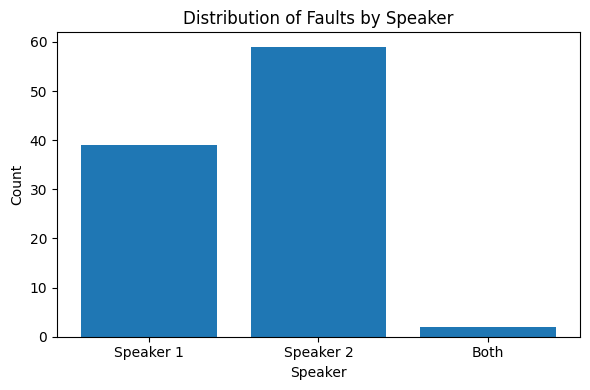

In [82]:
normalized_faults = []
for r in results_loaded:
    fault = r['fault'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    else:
        normalized_faults.append("Both")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Faults by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
### **Feedback on How Communication Can be Improved**


In [ ]:
def provide_feedback_workplace(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 uses an indirect speech act and Speaker 2 responds to it literally. As a communication expert, what feedback would you provide to the speaker(s)? Output a dictionary formatted as follows: { "feedback":"Your feedback, if any."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [ ]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


In [ ]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = provide_feedback_workplace(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(10)))


In [ ]:
with open('indirect_analysis_data/workplace/provide_feedback.json', 'w') as f:
    json.dump(results, f, indent=2)


In [ ]:
with open('indirect_analysis_data/workplace/provide_feedback.json') as f:
    results_loaded = json.load(f)

results_loaded[0:10]


In [ ]:
### **Feedback - Autistic**


In [ ]:
def provide_feedback_autistic_workplace(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 uses an indirect speech act and Speaker 2 responds to it literally. As a communication expert, what feedback would you provide to the speaker 2, provided they are autistic? Output a dictionary formatted as follows: { "feedback":"Your feedback, if any."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [ ]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


In [ ]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = provide_feedback_autistic_workplace(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(10)))


In [ ]:
with open('indirect_analysis_data/workplace/autistic_two_feedback.json', 'w') as f:
    json.dump(results, f, indent=2)


In [ ]:
with open('indirect_analysis_data/workplace/autistic_two_feedback.json') as f:
    results_loaded = json.load(f)

results_loaded[0:10]


In [ ]:
### **Feedback - Non-autistic**


In [ ]:
def provide_feedback_non_autistic_workplace(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 uses an indirect speech act and Speaker 2 responds to it literally. As a communication expert, what feedback would you provide to the speaker 2, provided they are not autistic? Output a dictionary formatted as follows: { "feedback":"Your feedback, if any."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [ ]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


In [ ]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = provide_feedback_non_autistic_workplace(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(10)))


In [ ]:
with open('indirect_analysis_data/workplace/non_autistic_two_feedback.json', 'w') as f:
    json.dump(results, f, indent=2)


In [ ]:
with open('indirect_analysis_data/workplace/non_autistic_two_feedback.json') as f:
    results_loaded = json.load(f)

results_loaded[0:10]


In [ ]:
### **Identify Autistic Speaker**


In [ ]:
def identify_autistic_speaker(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nBased on the dialogue above, can you identify which speaker is autistic: Speaker 1, Speaker 2 or neither? Explain your decision. Output a dictionary formatted as follows: { "autistic":"Speaker # or neither", "explanation":"A detailed explanation for your decision."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [ ]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


In [ ]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = identify_autistic_speaker(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [ ]:
with open('indirect_analysis_data/workplace/autistic_speaker.json', 'w') as f:
    json.dump(results, f, indent=2)


In [ ]:
with open('indirect_analysis_data/workplace/autistic_speaker.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


In [ ]:
normalized_faults = []
for r in results_loaded:
    fault = r['autistic'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Autistic Speakers")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
